<div style="text-align: center;">
    <h1> <font style="bold"> Trabajo Práctico 2 </font></h1>
    <h2><font style="bold">Regresión del valor medio de casas en distritos de California</font></h2>
    <h3><font style="bold">Abril Noguera - Pablo Brahim - Fermin Rodriguez - Kevin Pennington</font></h3>
</div>

Se requiere construir una regresión que nos permita predecir el valor medio de las casas en distritos de California, EEUU (medidos en cientos de miles de dólares $100,000). Este dataset se deriva del censo de 1990 de EEUU, donde cada 
observación es un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EEUU publica datos de muestra (un bloque típicamente tiene una población de 600 a 3000 personas).

Los atributos, en el orden en que se guardaron en el dataset, son:

- `MedInc`: Ingreso medio en el bloque
- `HouseAge`: Edad mediana de las casas en el bloque
- `AveRooms`: Número promedio de habitaciones por hogar.
- `AveBedrms`: Número promedio de dormitorios por hogar.
- `Population`: Población del bloque
- `AveOccup`: Número promedio de miembros por hogar.
- `Latitude`: Latitud del bloque
- `Longitude`: Longitud del bloque

Y el target es:

- `MedHouseVal`: Mediana del costo de casas en el bloque (en unidades de a $100.000)

Para este TP, se proporciona una notebook (`ayuda.ipynb`) con la lectura del dataset, la separación de los datos, entre 
otras ayudas para resolver este trabajo práctico.


In [2]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Leemos el dataset
california_housing = fetch_california_housing()

# Y obtenemos los atributos y target
X = california_housing.data
y = california_housing.target

# Transformamos en Pandas
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos a X e y, esto ayuda a la parte de la gráfica del mapa de calor de correlación
df = pd.concat([X, y], axis=1)

----

## Link al Repositorio
Adjunto el link al repositorio con la resulución completa. [Repositorio de Github](https://github.com/abrilnoguera/TP2-IIA)

--- 

### 1.  Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o directamente graficar usando un mapa de calor.

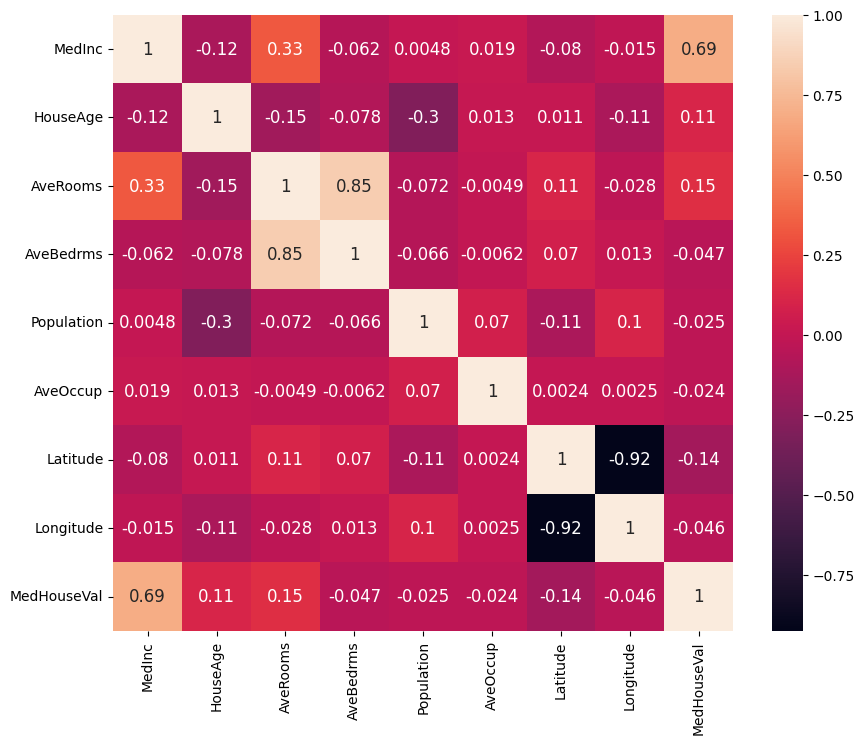

In [14]:
correlations = df.corr()
plt.figure(figsize=[10,8])
sns.heatmap(correlations, annot=True, annot_kws={'size':12})
plt.show()

El atributo con mayor correlación lineal con el target es el ingreso medio del bloque (MeInc) con un coeficiente de 0.69. La correlación es bastante alta lo cual es esperable ya que, a mayor ingreso del bloque, mayor debe ser el costo medio de las propiedades.
Entre los atributos no se observa en general correlaciones muy grandes. El -0.92 es el mayor valor pero es la correlación entre las coordenadas de California. Otra correlación alta entre atributos es la de numero promedio de habitaciones y dormitorios. 
Finalmente, otro valor que resalta es el promedio de habitaciones e ingreso medio del bloque con un coeficiente de 0.33. Este valor crece notablemente si se excluye el 0.01 de valores superiores de promedio de habitaciones.

In [55]:
df.describe(percentiles=[0.01, 0.5, 0.99])

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
1%,1.069631,4.000000,2.581133,0.872840,88.000000,1.536686,32.680000,-123.220000,0.500000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
99%,10.596540,52.000000,10.357033,2.127541,5805.830000,5.394812,40.626100,-116.290000,5.000010
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Se excluyeron 207 valores del data frame


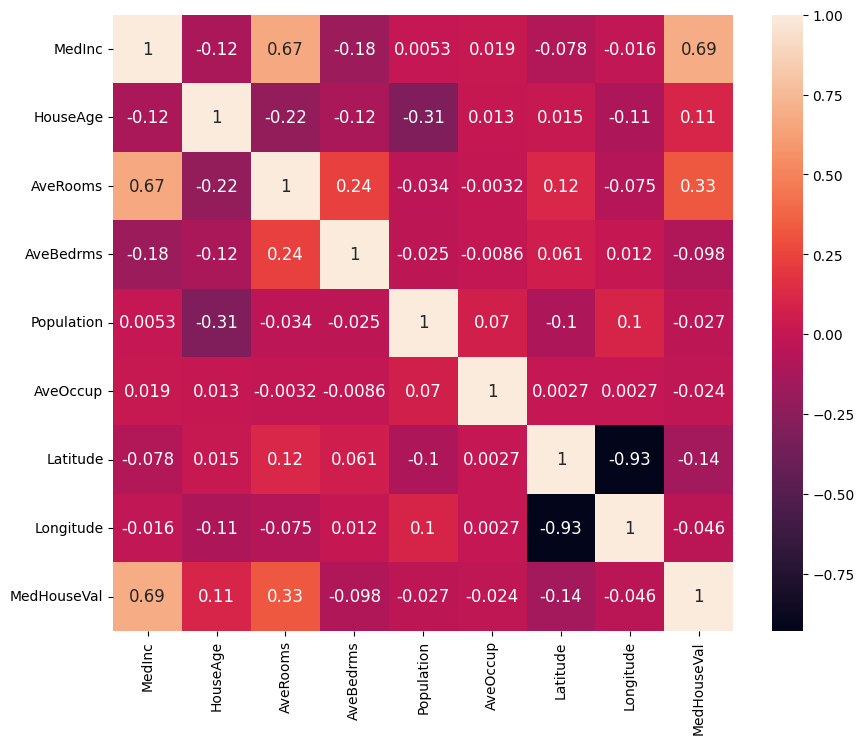

In [70]:
df_aux = df.loc[ (df["AveRooms"] < df.quantile(0.99)["AveRooms"])]
plt.figure(figsize=[10,8])
correlations =df_aux.corr()
sns.heatmap(correlations, annot=True, annot_kws={'size':12})
print(f"Se excluyeron {df.shape[0] - df_aux.shape[0]} valores del data frame")

En este caso, la correlación entre el ingreso medio y la cantidad de habitaciones crece a un 0.67
Solo para visualizar lo que se está excluyendo con ese 0.01%:

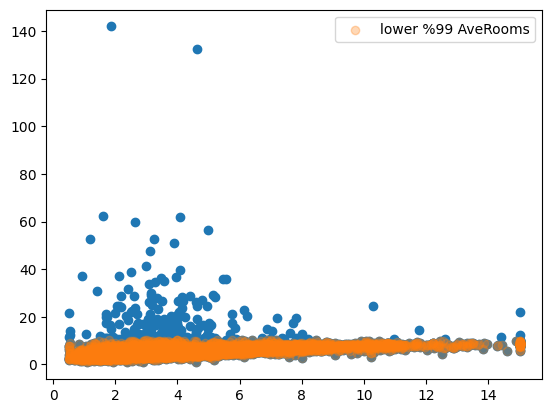

In [95]:
plt.scatter(df.MedInc, df.AveRooms)
plt.scatter(df_aux.MedInc, df_aux.AveRooms, alpha=0.3, label="lower %99 AveRooms" )
plt.legend()

---
### 2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin  entrar en pruebas de hipótesis?

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


In [92]:
def plot_hist(df, column, quantile=0.99, bins=30):

    threshold = df[column].quantile(quantile)
    df_filtered = df[df[column] < threshold]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.histplot(df[column], ax=axes[0], bins=bins, color="steelblue")
    axes[0].set_title(f"All data — {column}")

    sns.histplot(df_filtered[column], ax=axes[1], bins=bins, color="seagreen", kde=True)
    axes[1].set_title(f"Filtered < {quantile:.0%} — {column}")

    plt.tight_layout()
    plt.savefig("a.png")
    plt.show()

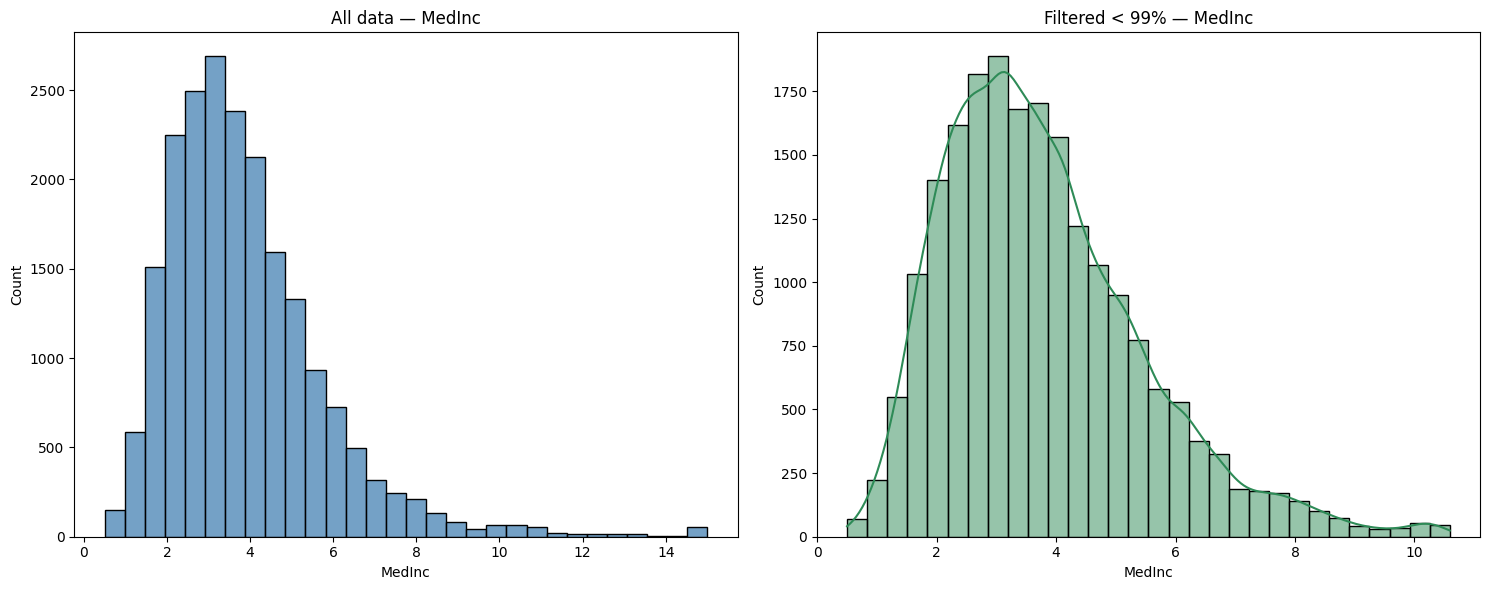

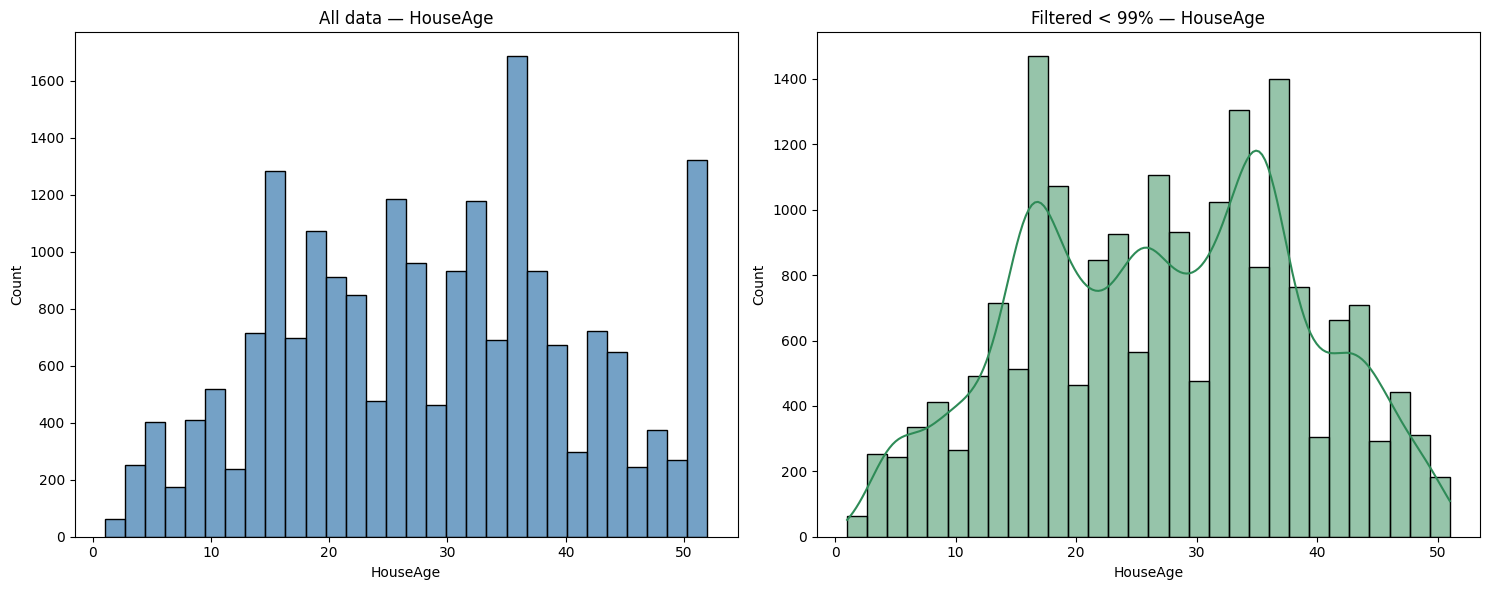

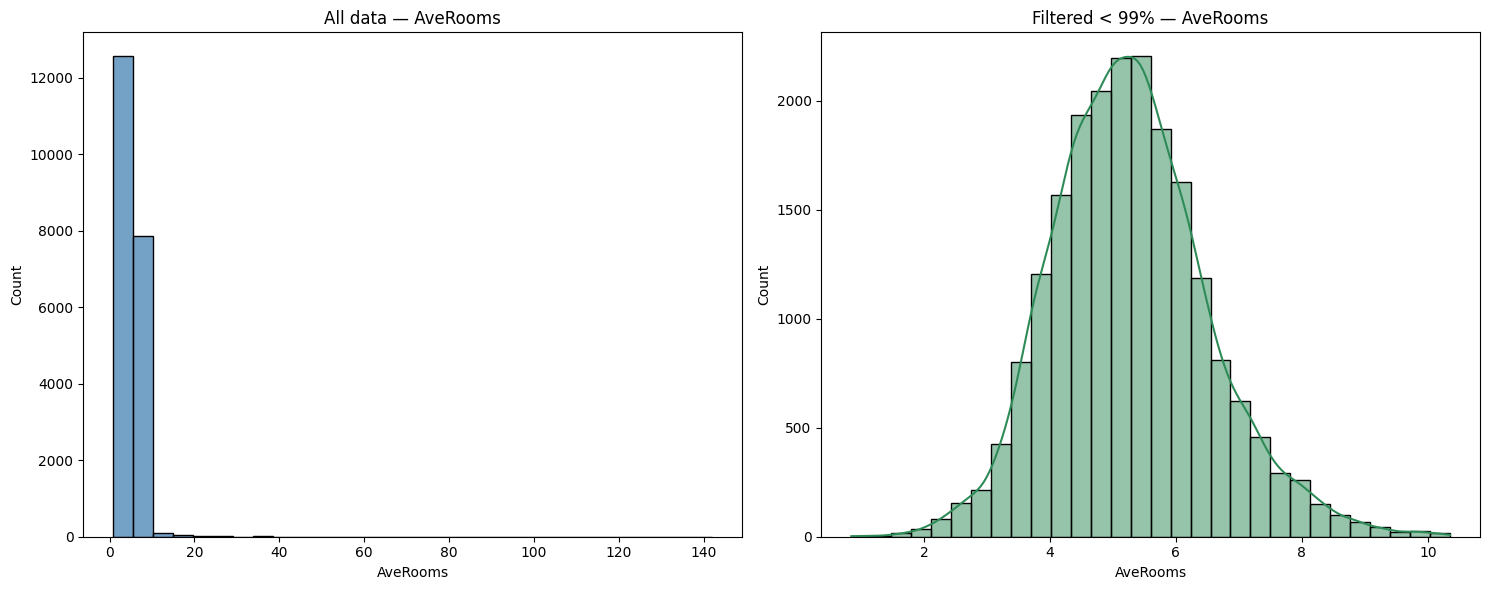

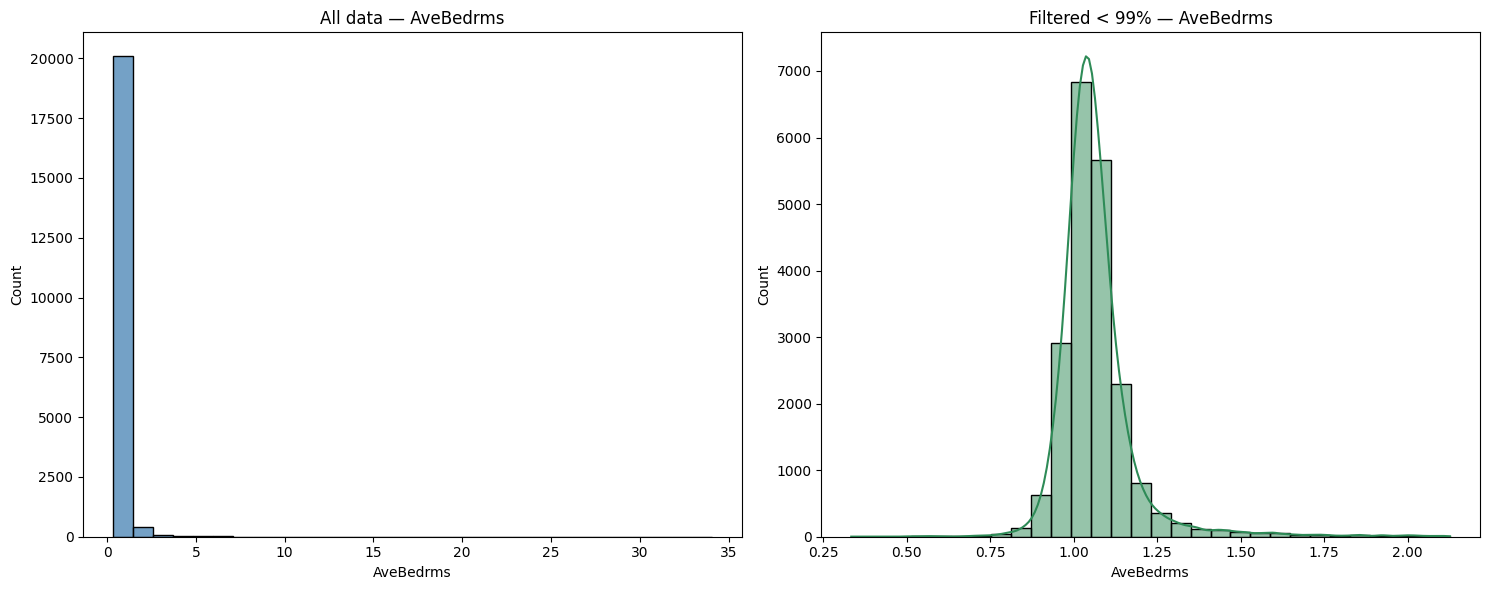

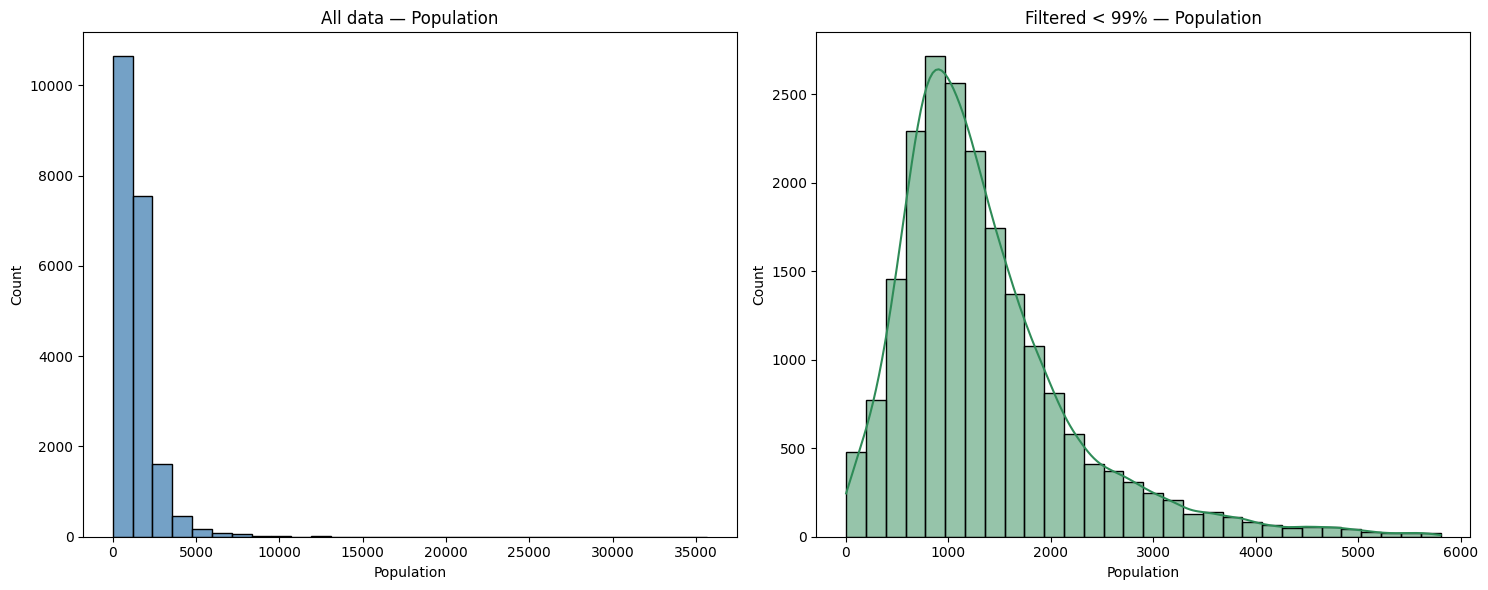

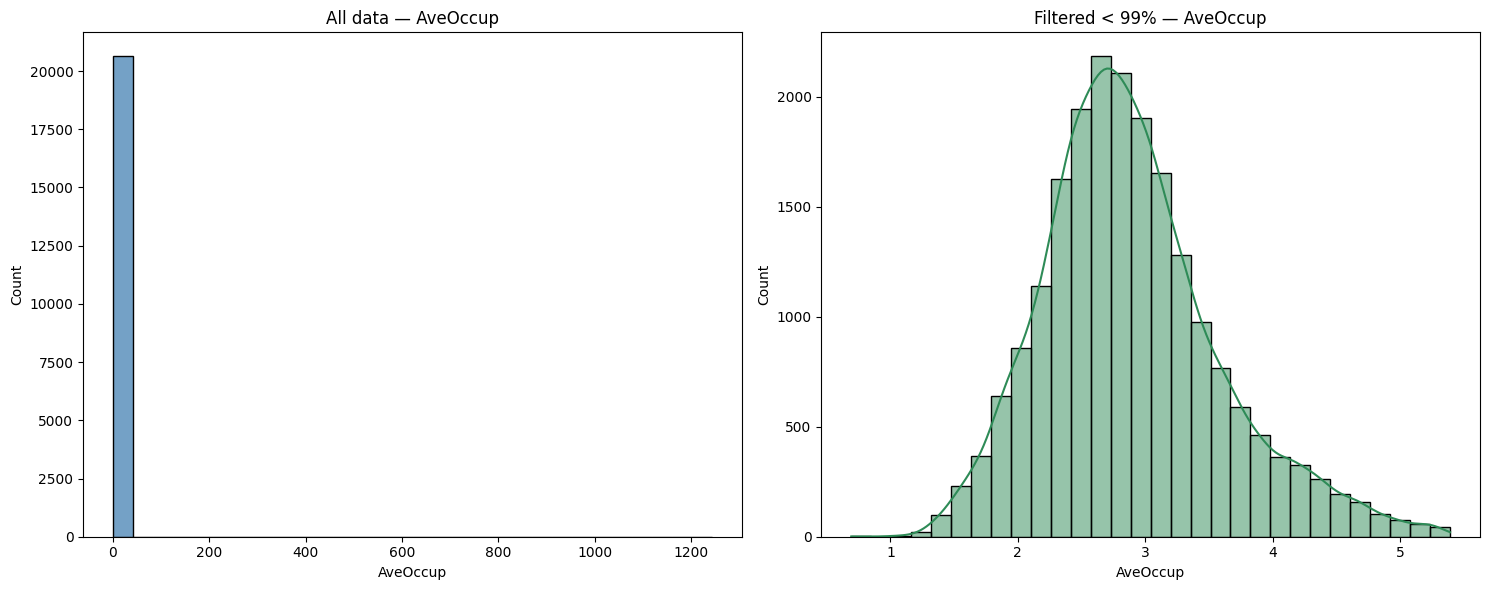

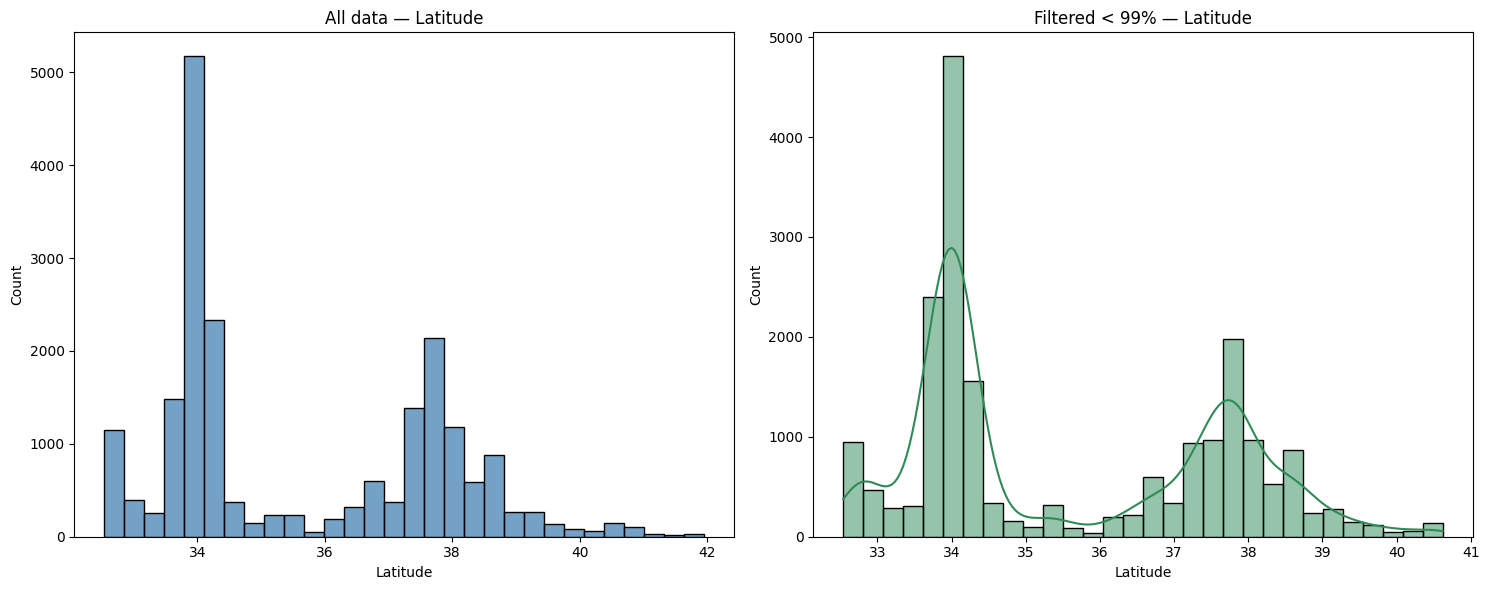

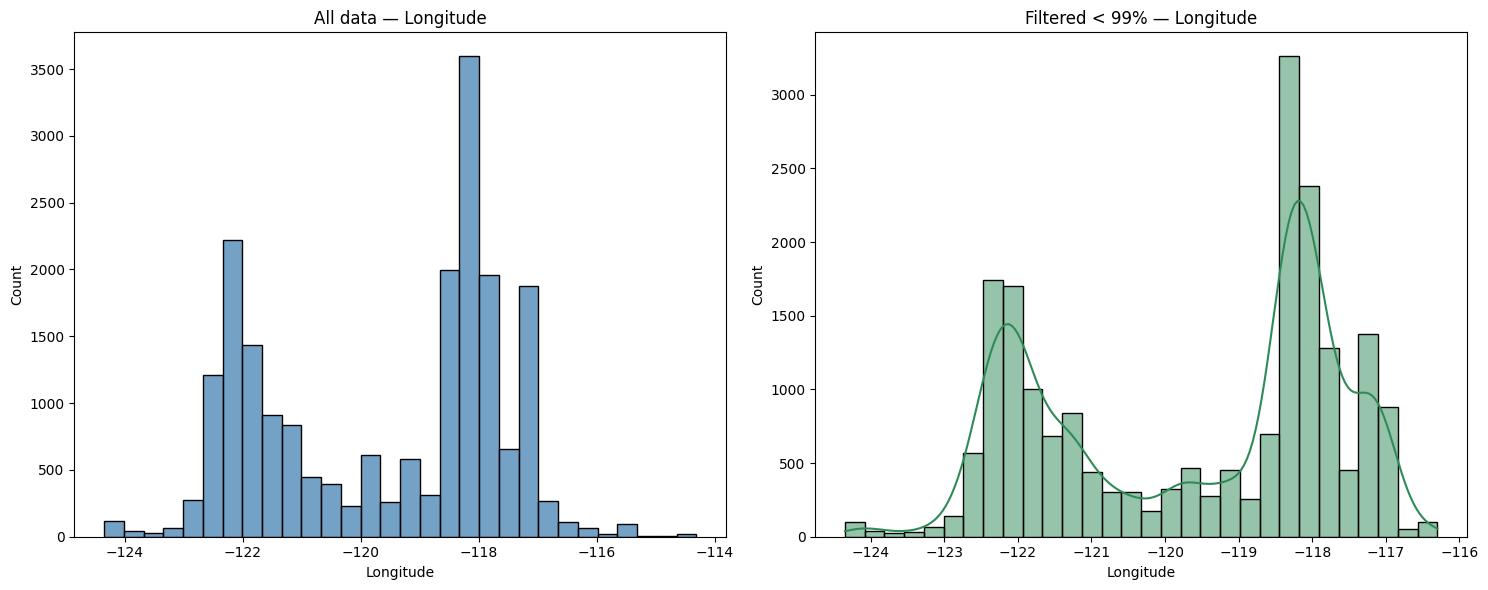

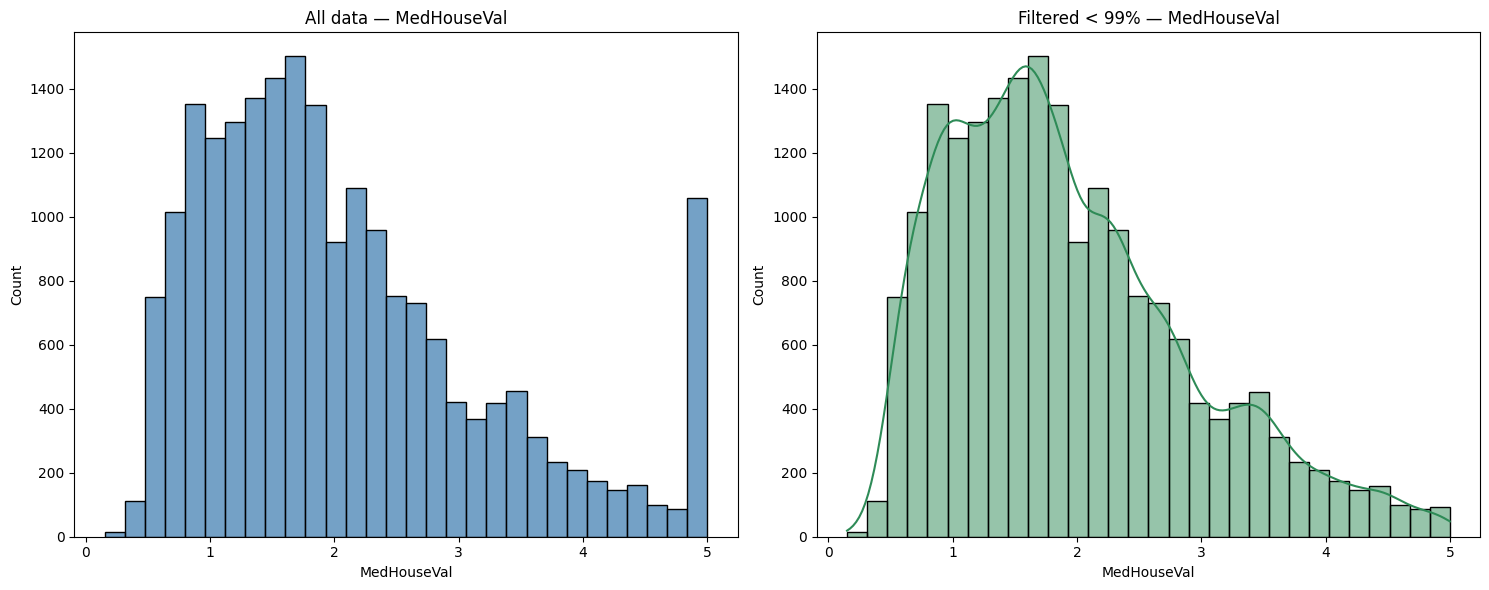

In [87]:
for col in df.columns:
    plot_hist(df,col)

En general (excluyendo latitud y longitud) los datos presentan forma de campana. Esto se hace mas visible filtrando el 99% inferior de los datos.
La mayoría no parecen distribuciones gaussianas sin embargo como sugieren las colas sesgadas? _skewed_ generalmente hacia la derecha.
Posiblemente sean log-norm, lo que podria comprobarse tomando log y evaluando si es normal. MediaInc, Population y AveOccup son los atrubutos donde este comportamiento se hace mas evidente.

---
### 3. Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su  respuesta.

In [5]:
from sklearn.model_selection import train_test_split


# Dividimos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Creamos el pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

In [7]:
# Entrenamos el modelo
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [8]:
import numpy as np
from sklearn.metrics import r2_score

# Predecir y evaluar
y_pred_train = pipe.predict(X_train)

# Calcular varianza total y explicada
var_total = np.var(y_train)
var_residual = np.var(y_train - y_pred_train)
var_explicada = var_total - var_residual
r2 = r2_score(y_train, y_pred_train) # porcentaje de varianza explicada

# Resultados
print("Resultados del modelo en Train:")
print(f"Varianza total del target: {var_total:.4f}")
print(f"Varianza explicada por el modelo: {var_explicada:.4f}")
print(f"R²: {r2:.2%}")

Resultados del modelo en Train:
Varianza total del target: 1.3397
Varianza explicada por el modelo: 0.8163
R²: 60.93%


El modelo está explicando un 60.93% de la variabilidad del target, lo cual no es perfecto pero tampoco bajo. Esto quiere decir que, aunque el modelo logra reconocer ciertos patrones importantes en los datos, todavía hay una parte considerable (alrededor del 39%) que no está pudiendo explicar. Es decir, hay aspectos del comportamiento del target que el modelo no está captando del todo.

---
### 4. Calcular las métricas de MSE, MAE y $R^2$ del set de evaluación.

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Predecir sobre el set de test
y_pred = pipe.predict(X_test)

# 2. Calcular métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 3. Mostrar resultados
print("Resultados del modelo en Test:")
print(f"MSE (Error cuadrático medio): {mse:.4f}")
print(f"MAE (Error absoluto medio):  {mae:.4f}")
print(f"R² (Varianza explicada):     {r2:.2%}")

Resultados del modelo en Test:
MSE (Error cuadrático medio): 0.5306
MAE (Error absoluto medio):  0.5272
R² (Varianza explicada):     59.58%


---
### 5. Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de $\alpha$, buscando entre [0, 12.5]. Graficar el valor de MSE versus $\alpha$.

Mejor alpha: 3.0303


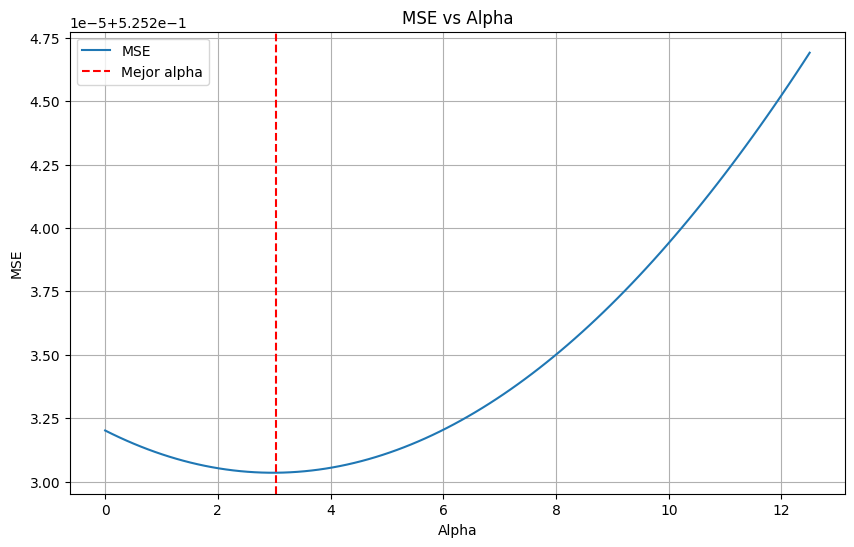

In [10]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score

alphas = np.linspace(0, 12.5, 100)
mses = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for alpha in alphas:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(alpha=alpha))
    ])

    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    mse = -np.mean(scores)
    mses.append(mse)

best_alpha = alphas[np.argmin(mses)]
print(f"Mejor alpha: {best_alpha:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(alphas, mses, label='MSE')
plt.axvline(x=best_alpha, color='r', linestyle='--', label='Mejor alpha')
plt.title('MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()


In [ ]:
ridge_model = Ridge(alpha=best_alpha)

ridge_model.fit(X_train, y_train)

y_pred_train = ridge_model.predict(X_train)

var_total = np.var(y_train)
var_residual = np.var(y_train - y_pred_train)
var_explicada = var_total - var_residual
r2 = r2_score(y_train, y_pred_train) # porcentaje de varianza explicada

print(f"Varianza total del target: {var_total:.4f}")
print(f"Varianza explicada por el modelo: {var_explicada:.4f}")
print(f"R²: {r2:.2%}")





---
### 6. Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?

In [ ]:
# Resultados de Regresión Lineal (ya calculados en el punto 4)
mse_linear = 0.5306
mae_linear = 0.5272
r2_linear = 0.5958  # 59.58%

# Entrenar y evaluar Ridge con mejor alpha (3.0303)
best_ridge = Ridge(alpha=3.0303)
best_ridge.fit(X_train, y_train)
y_pred_ridge = best_ridge.predict(X_test)

# Calcular métricas para Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Comparación
print("Comparación en set de evaluación:\n")
print(f"{'Métrica':<10}{'Lineal':<10}{'Ridge':<10}{'Mejora (%)':<10}")
print(f"{'-'*40}")
print(f"{'MSE':<10}{mse_linear:.4f}{mse_ridge:>10.4f}{(mse_linear-mse_ridge)/mse_linear*100:>10.2f}%")
print(f"{'MAE':<10}{mae_linear:.4f}{mae_ridge:>10.4f}{(mae_linear-mae_ridge)/mae_linear*100:>10.2f}%")
print(f"{'R²':<10}{r2_linear:.2%}{r2_ridge:>10.2%}{(r2_ridge-r2_linear)/abs(r2_linear)*100:>10.2f}%")

In [ ]:
MSE: Ridge (0.5304) es marginalmente mejor que Lineal (0.5306), con una mejora del 0.04%
MAE: Lineal (0.5272) es ligeramente mejor que Ridge (0.5273), con una diferencia mínima del -0.01%
Ambos modelos tienen un rendimiento casi idéntico en el set de evaluación, con diferencias estadísticamente insignificantes.

La mejora casi imperceptible puede deberse a:
Estructura de los datos: No presentan problemas graves de multicolinealidad (que Ridge suele corregir)
Tamaño muestral: Con suficientes datos la regresión lineal simple ya generaliza bien
Alpha óptimo: El valor de regularización encontrado (3.03) es bajo, indicando poca necesidad de regularización
Naturaleza del problema: Las relaciones entre predictores y target son fundamentalmente lineales

Ridge reduce el error de varianza, aunque el impacto fue minimo en este caso.     


# Link al Notebook
Se puede encontrar el trabajo completo en el siguiente link: [Repositorio GitHub](https://github.com/abrilnoguera/TP2-IIA)